# Loading libraries

In [1]:
from typing import List, Union, Dict
import sys
import os
import glob
import datetime
import yaml
import warnings
sys.path.insert(1, '..')
os.chdir('..')

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime

# Processing

## Load data

In [2]:
import pandas as pd

# Set working directory
data_dir = "D:/PhD/Datasets/T1DEXI_Adults/000-jaeb-adult/T1DEXI - DATA FOR UPLOAD/T1DEXI - DATA FOR UPLOAD/"

# Read .xpt files
CM = pd.read_sas(f"{data_dir}CM.xpt", format='xport')
DI = pd.read_sas(f"{data_dir}DI.xpt", format='xport')
DM = pd.read_sas(f"{data_dir}DM.xpt", format='xport')
DX = pd.read_sas(f"{data_dir}DX.xpt", format='xport')
# FA = pd.read_sas(f"{data_dir}FA.xpt", format='xport')
FACM = pd.read_sas(f"{data_dir}FACM.xpt", format='xport')
FADX = pd.read_sas(f"{data_dir}FADX.xpt", format='xport')
FAMLPI = pd.read_sas(f"{data_dir}FAMLPI.xpt", format='xport')
FAMLPM = pd.read_sas(f"{data_dir}FAMLPM.xpt", format='xport')
FAMLPD = pd.read_sas(f"{data_dir}FAMLPD.xpt", format='xport')
LB = pd.read_sas(f"{data_dir}LB.xpt", format='xport')
ML = pd.read_sas(f"{data_dir}ML.xpt", format='xport')
NV = pd.read_sas(f"{data_dir}NV.xpt", format='xport')
PR = pd.read_sas(f"{data_dir}PR.xpt", format='xport')
QS = pd.read_sas(f"{data_dir}QS.xpt", format='xport')
RP = pd.read_sas(f"{data_dir}RP.xpt", format='xport')
SC = pd.read_sas(f"{data_dir}SC.xpt", format='xport')
SUPPDM = pd.read_sas(f"{data_dir}SUPPDM.xpt", format='xport')
# VS = pd.read_sas(f"{data_dir}VS.xpt", format='xport')


## Glucose data

3.3.11 LB - Laboratory Test Results 
The LB domain contains records for most recent HbA1c as reported by participant at baseline, and Dexcom G6 
continuous glucose monitoring (CGM) data during study period. Dexcom G6 data is typically recorded once 
every five minutes.  

In [3]:
glucose_df = LB[['USUBJID', 'LBDTC', 'LBCAT', 'LBORRES']]
glucose_df

,USUBJID,LBDTC,LBCAT,LBORRES
0,b'1',1.904774e+09,b'CGM',115.0
1,b'1',1.904775e+09,b'CGM',109.0
2,b'1',1.904775e+09,b'CGM',105.0
3,b'1',1.904775e+09,b'CGM',106.0
4,b'1',1.904776e+09,b'CGM',110.0
...,...,...,...,...
3785750,b'988',1.934236e+09,b'CGM',94.0
3785751,b'988',1.934236e+09,b'CGM',95.0
3785752,b'988',1.934236e+09,b'CGM',93.0
3785753,b'988',1.934237e+09,b'CGM',90.0


In [4]:
# convert the diabetes history from a raw to a column
# Filter the rows with LBCAT == 'DIABETES HISTORY'
diabetes_history = glucose_df[glucose_df['LBCAT'] == b'DIABETES HISTORY'][['USUBJID', 'LBORRES']]

# Convert USUBJID to integers
diabetes_history['USUBJID'] = diabetes_history['USUBJID'].apply(lambda x: int(x.decode('utf-8')))
diabetes_history = diabetes_history.rename(columns={'LBORRES': 'HbA1C'})

# Convert the main DataFrame's USUBJID to integers
glucose_df.loc[:, 'USUBJID'] = glucose_df['USUBJID'].apply(lambda x: int(x.decode('utf-8')))

# Merge diabetes history information back into the main DataFrame
glucose_df = glucose_df[glucose_df['LBCAT'] != b'DIABETES HISTORY']  # Remove rows with LBCAT == 'DIABETES HISTORY'
glucose_df = glucose_df.merge(diabetes_history, on='USUBJID', how='left')

# convert column to timestamp
glucose_df['LBDTC'] = pd.to_datetime(glucose_df['LBDTC'], unit='s')

# Rename columns for consistency
glucose_df = glucose_df.rename(columns={'USUBJID': 'id', 'LBDTC': 'time', 'LBORRES': 'gl'})

# drop LBCAT column
glucose_df = glucose_df.drop(columns=['LBCAT'])

# Display the result
glucose_df

,id,time,gl,HbA1C
0,1,2030-05-12 00:01:17,115.0,7.0
1,1,2030-05-12 00:06:17,109.0,7.0
2,1,2030-05-12 00:11:17,105.0,7.0
3,1,2030-05-12 00:16:18,106.0,7.0
4,1,2030-05-12 00:21:18,110.0,7.0
...,...,...,...,...
3785248,988,2031-04-17 23:36:40,89.0,6.3
3785249,988,2031-04-17 23:41:40,94.0,6.3
3785250,988,2031-04-17 23:46:40,95.0,6.3
3785251,988,2031-04-17 23:51:40,93.0,6.3


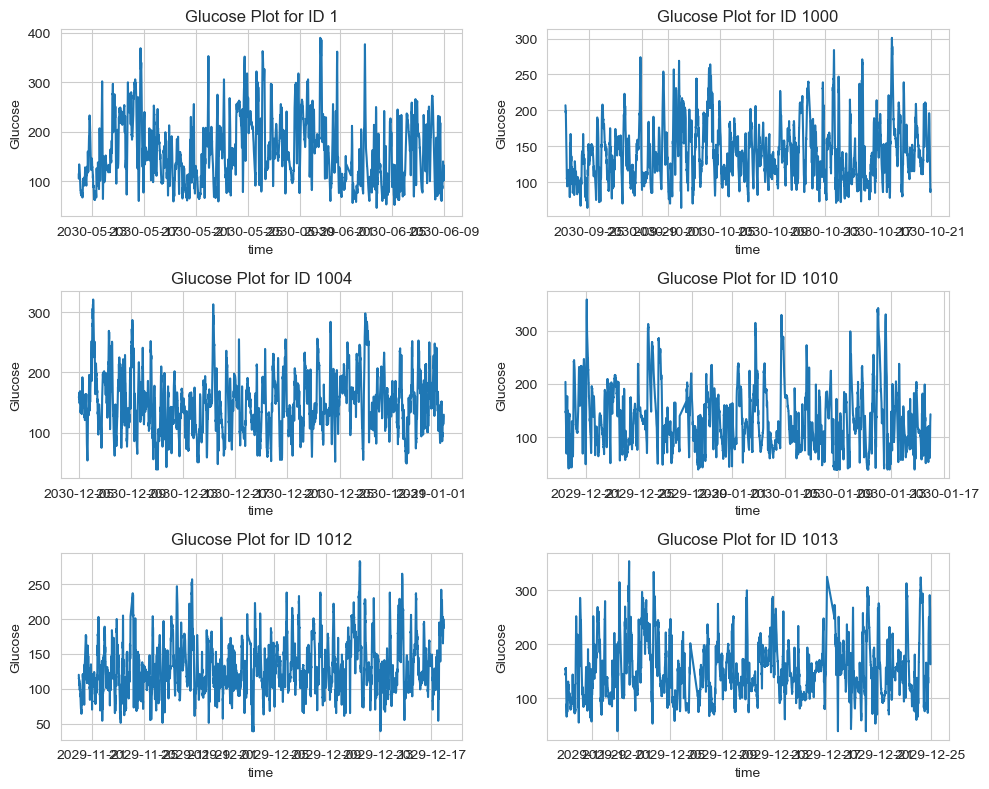

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Select the first 5 unique IDs
selected_ids = glucose_df['id'].unique()[:6]
df_subset = glucose_df[glucose_df['id'].isin(selected_ids)]

# Group the subset by 'id'
groups = df_subset.groupby('id')

# Set up subplots
num_cols = 2
num_rows = int(np.ceil(len(groups) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 8))

# Flatten axs in case of single row or single column
axs = axs.flatten()

# Plot each selected ID
for i, (group_name, group) in enumerate(groups):
    ax = axs[i]
    ax.plot(group['time'], group['gl'])
    ax.set_xlabel('time')
    ax.set_ylabel('Glucose')
    ax.set_title(f'Glucose Plot for ID {group_name}')

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


# Check Nan values of the data

In [ ]:
glucose_df.isna().sum()

id       0
time     0
gl       0
HbA1C    0
dtype: int64

In [ ]:
glucose_df.to_csv('C:\PhD\codeAIHN\imputation_OOR\data\T1DEXI_adults.csv', index=False)

In [50]:
import pandas as pd

def fill_intervals_with_nan_per_id(
    df, id_col, time_col="time", interval_col="minutes_elapsed", fill_interval=5
):
    """
    Fills intervals greater than the fill interval with rows containing NaN values for every `fill_interval` minutes per ID.
    Args:
    - df (pd.DataFrame): The dataframe with the ID, time, and interval columns.
    - id_col (str): The name of the ID column.
    - time_col (str): The name of the time column.
    - interval_col (str): The name of the interval column.
    - fill_interval (int): The interval in minutes to insert rows.
    Returns:
    - pd.DataFrame: The modified dataframe with added rows containing NaN values.
    """
    # Convert time_col to datetime
    df[time_col] = pd.to_datetime(df[time_col], format="%d/%m/%Y %H:%M")

    # Create a list to store the processed data for each ID
    result = []

    # Process each group separately
    for id_val, group in df.groupby(id_col):
        group = group.sort_values(by=time_col).reset_index(drop=True)

        # Calculate time differences in minutes within the group
        group["time_diff"] = group[time_col].diff().dt.total_seconds() / 60

        new_rows = []
        for i in range(1, len(group)):
            gap = group.loc[i, "time_diff"]
            if gap >= fill_interval:
                # Find the start and end times of the gap
                start_time = group.loc[i - 1, time_col]
                end_time = group.loc[i, time_col]

                # Generate missing timestamps
                missing_times = pd.date_range(
                    start=start_time + pd.Timedelta(minutes=fill_interval),
                    end=end_time - pd.Timedelta(minutes=fill_interval-1),
                    freq=f"{fill_interval}min",
                )

                # Create rows with NaN values for these missing timestamps
                for time in missing_times:
                    new_row = {
                        id_col: id_val,
                        time_col: time,
                        interval_col: None,
                        "time_diff": None,
                    }
                    new_rows.append(new_row)

        # Append the missing rows to the original group
        if new_rows:
            new_group = pd.DataFrame(new_rows)
            group = pd.concat([group, new_group], ignore_index=True)
            group = group.sort_values(by=time_col).reset_index(drop=True)
            group = group.drop_duplicates(subset=[time_col], keep="first")

        # Drop the temporary column
        group.drop(columns=["time_diff"], inplace=True)

        # Append the processed group to the result list
        result.append(group)

    # Concatenate all processed groups back together
    df_filled = pd.concat(result, ignore_index=True)
    # df_filled = df_filled.sort_values(by="id").reset_index(drop=True)

    return df_filled


In [51]:
df_filled = fill_intervals_with_nan_per_id(glucose_df, id_col="id")

C:\Users\Maria Panagiotou\AppData\Local\Temp\ipykernel_12528\3586350885.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  group = pd.concat([group, new_group], ignore_index=True)
C:\Users\Maria Panagiotou\AppData\Local\Temp\ipykernel_12528\3586350885.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  group = pd.concat([group, new_group], ignore_index=True)
C:\Users\Maria Panagiotou\AppData\Local\Temp\ipykernel_12528\3586350885.py:58: FutureWarning: The behavior of DataFrame concatenation wi

In [52]:
df_filled.isna().sum() 

id                       0
time                     0
gl                  164841
HbA1C               164841
minutes_elapsed    3950083
dtype: int64

In [53]:
# save as Dubosson_processed_with_covariates.csv
df_filled.to_csv('C:\PhD\codeAIHN\imputation_OOR\data\T1DEXI_adults.csv', index=False)

## Insulin covariates

3.3.6 FACM - Findings About Concomitant Medications 
FACM domain contains individual basal and bolus records, and basal flow rate, from participants’ personal 
insulin pump(s), as indicated in CM domain.  

In [72]:
FACM

,STUDYID,DOMAIN,USUBJID,FASEQ,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FASTRESC,FASTRESN,FASTRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL
0,b'T1DEXI',b'FA',b'1',544.0,b'INSBASAL',b'BASAL INSULIN',b'INSULIN',b'BASAL',b' 28.0000000000',b'U',b' 28.0000000000',28.00,b'U',1.904858e+09,b'',b'Injections',b'',NaN,NaN
1,b'T1DEXI',b'FA',b'1',545.0,b'INSBASAL',b'BASAL INSULIN',b'INSULIN',b'BASAL',b' 1.0000000000',b'U',b' 1.0000000000',1.00,b'U',1.904887e+09,b'',b'Injections',b'',NaN,NaN
2,b'T1DEXI',b'FA',b'1',546.0,b'INSBASAL',b'BASAL INSULIN',b'INSULIN',b'BASAL',b' 1.0000000000',b'U',b' 1.0000000000',1.00,b'U',1.904978e+09,b'',b'Injections',b'',NaN,NaN
3,b'T1DEXI',b'FA',b'1',547.0,b'INSBASAL',b'BASAL INSULIN',b'INSULIN',b'BASAL',b' 1.0000000000',b'U',b' 1.0000000000',1.00,b'U',1.905058e+09,b'',b'Injections',b'',NaN,NaN
4,b'T1DEXI',b'FA',b'1',548.0,b'INSBASAL',b'BASAL INSULIN',b'INSULIN',b'BASAL',b' 20.0000000000',b'U',b' 20.0000000000',20.00,b'U',1.905120e+09,b'',b'Injections',b'',NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2217153,b'T1DEXI',b'FA',b'988',35034.0,b'INSBOLUS',b'BOLUS INSULIN',b'INSULIN',b'BOLUS',b' 1.0800000000',b'U',b' 1.0800000000',1.08,b'U',1.934208e+09,b'',b'Pump',b'normal',1.08,NaN
2217154,b'T1DEXI',b'FA',b'988',35035.0,b'INSBOLUS',b'BOLUS INSULIN',b'INSULIN',b'BOLUS',b' 0.3300000000',b'U',b' 0.3300000000',0.33,b'U',1.934208e+09,b'',b'Pump',b'normal',0.33,NaN
2217155,b'T1DEXI',b'FA',b'988',35036.0,b'INSBOLUS',b'BOLUS INSULIN',b'INSULIN',b'BOLUS',b' 1.4200000000',b'U',b' 1.4200000000',1.42,b'U',1.934221e+09,b'',b'Pump',b'normal',1.42,NaN
2217156,b'T1DEXI',b'FA',b'988',35037.0,b'INSBOLUS',b'BOLUS INSULIN',b'INSULIN',b'BOLUS',b' 0.3600000000',b'U',b' 0.3600000000',0.36,b'U',1.934226e+09,b'',b'Pump',b'normal',0.36,NaN


## Food Data

3.3.8 FAMLPD - Findings About Meal Data (per day) 
The Remote Food Photography Method (RFPM) was developed to measure the energy and nutrient intake of 
people while they live in their natural environment. Food images are then sent via the wireless network and are 
stored in a custom-built computer program called the Food Photography Application. Based on previously 
described and validated methods, participants’ energy and nutrient intake is then estimated by comparing their 
food images to images of foods with a known portion size. These images are contained in a searchable 
“archive”, which provides: a standard portion image for portion size estimation, and a match to the Food and 
Nutrient Database for Dietary Studies, the producer’s nutrient information, or a custom recipe for energy and 
nutrient calculation. Image analysis is performed with a semi-automated process that relies on human raters and 
computer automation. A reference card is used to correct/standardize images for color and perspective, which 
facilitates analysis of the food images by both human raters and computer applications. 
FAMLPD contains consumed, taken, and returned RFPM food intake estimates for all macronutrients, 
micronutrients, and food groups at a daily level, as well as consumed, returned, and taken total grams. 

3.3.9 FAMLPM - Findings About Meal Data (per meal) 
The Remote Food Photography Method (RFPM) was developed to measure the energy and nutrient intake of 
people while they live in their natural environment. Food images are then sent via the wireless network and are 
stored in a custom-built computer program called the Food Photography Application. Based on previously 
described and validated methods, participants’ energy and nutrient intake is then estimated by comparing their 
food images to images of foods with a known portion size. These images are contained in a searchable 
“archive”, which provides: a standard portion image for portion size estimation, and a match to the Food and 
Nutrient Database for Dietary Studies, the producer’s nutrient information, or a custom recipe for energy and 
nutrient calculation. Image analysis is performed with a semi-automated process that relies on human raters and 
computer automation. A reference card is used to correct/standardize images for color and perspective, which 
facilitates analysis of the food images by both human raters and computer applications. 
FAMLPM contains consumed, taken, and returned RFPM food intake estimates for all macronutrients, 
micronutrients, and food groups at a meal level, as well as consumed, returned, and taken total grams. 

3.3.10 FAMLPI - Findings About Meal Data (per item) 
The Remote Food Photography Method (RFPM) was developed to measure the energy and nutrient intake of 
people while they live in their natural environment. Food images are then sent via the wireless network and are 
stored in a custom-built computer program called the Food Photography Application. Based on previously 
described and validated methods, participants’ energy and nutrient intake is then estimated by comparing their 
food images to images of foods with a known portion size. These images are contained in a searchable 
“archive”, which provides: a standard portion image for portion size estimation, and a match to the Food and 
Nutrient Database for Dietary Studies, the producer’s nutrient information, or a custom recipe for energy and 
nutrient calculation. Image analysis is performed with a semi-automated process that relies on human raters and computer automation. A reference card is used to correct/standardize images for color and perspective, which 
facilitates analysis of the food images by both human raters and computer applications. 
FAMLPI contains consumed, taken, and returned RFPM food intake estimates for all macronutrients, 
micronutrients, and food groups at an item level, as well as returned and taken total grams. 

3.3.12 ML - Meal Data 
The Remote Food Photography Method (RFPM) was developed to measure the energy and nutrient intake of 
people while they live in their natural environment. Food images are then sent via the wireless network and are 
stored in a custom-built computer program called the Food Photography Application. Based on previously 
described and validated methods, participants’ energy and nutrient intake is then estimated by comparing their 
food images to images of foods with a known portion size. These images are contained in a searchable 
“archive”, which provides: a standard portion image for portion size estimation, and a match to the Food and 
Nutrient Database for Dietary Studies, the producer’s nutrient information, or a custom recipe for energy and 
nutrient calculation. Image analysis is performed with a semi-automated process that relies on human raters and 
computer automation. A reference card is used to correct/standardize images for color and perspective, which 
facilitates analysis of the food images by both human raters and computer applications.  
ML domain contains RFPM method data about total consumed grams at the item level. 

In [73]:
FAMLPD

,STUDYID,DOMAIN,USUBJID,FASEQ,FATESTCD,FATEST,FAOBJ,FACAT,FASCAT,FAORRES,FAORRESU,FASTRESC,FASTRESN,FASTRESU,FAMETHOD,FAANMETH,FADTC
0,b'T1DEXI',b'FA',b'1000',107.0,b'ALCDRKN',b'Number of Alcoholic Drinks',b'DAILY TOTAL FOOD AND DRINK',b'TAKEN',b'ALCOHOLIC DRINKS',b'0.00',b'DRINK',b'0.00',5.397605e-79,b'DRINK',b'RFPM',b'FNDDS 2017-2018',1.917648e+09
1,b'T1DEXI',b'FA',b'1000',108.0,b'ALCDRKN',b'Number of Alcoholic Drinks',b'DAILY TOTAL FOOD AND DRINK',b'RETURNED',b'ALCOHOLIC DRINKS',b'0.00',b'DRINK',b'0.00',5.397605e-79,b'DRINK',b'RFPM',b'FNDDS 2017-2018',1.917648e+09
2,b'T1DEXI',b'FA',b'1000',109.0,b'ALCDRKN',b'Number of Alcoholic Drinks',b'DAILY TOTAL FOOD AND DRINK',b'CONSUMED',b'ALCOHOLIC DRINKS',b'0.00',b'DRINK',b'0.00',5.397605e-79,b'DRINK',b'RFPM',b'FNDDS 2017-2018',1.917648e+09
3,b'T1DEXI',b'FA',b'1000',110.0,b'ALCDRKN',b'Number of Alcoholic Drinks',b'DAILY TOTAL FOOD AND DRINK',b'TAKEN',b'ALCOHOLIC DRINKS',b'0.00',b'DRINK',b'0.00',5.397605e-79,b'DRINK',b'RFPM',b'FNDDS 2017-2018',1.917734e+09
4,b'T1DEXI',b'FA',b'1000',111.0,b'ALCDRKN',b'Number of Alcoholic Drinks',b'DAILY TOTAL FOOD AND DRINK',b'RETURNED',b'ALCOHOLIC DRINKS',b'0.00',b'DRINK',b'0.00',5.397605e-79,b'DRINK',b'RFPM',b'FNDDS 2017-2018',1.917734e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198297,b'T1DEXI',b'FA',b'988',35315.0,b'RETAMT',b'Returned Amount',b'DAILY TOTAL FOOD AND DRINK',b'RETURNED',b'TOTAL',b'0.00',b'g',b'0.00',5.397605e-79,b'g',b'RFPM',b'FNDDS 2017-2018',1.933805e+09
1198298,b'T1DEXI',b'FA',b'988',35316.0,b'RETAMT',b'Returned Amount',b'DAILY TOTAL FOOD AND DRINK',b'RETURNED',b'TOTAL',b'0.00',b'g',b'0.00',5.397605e-79,b'g',b'RFPM',b'FNDDS 2017-2018',1.933891e+09
1198299,b'T1DEXI',b'FA',b'988',266509.0,b'TKNAMT',b'Taken Amount',b'DAILY TOTAL FOOD AND DRINK',b'TAKEN',b'TOTAL',b'54.50',b'g',b'54.50',5.450000e+01,b'g',b'RFPM',b'FNDDS 2017-2018',1.932682e+09
1198300,b'T1DEXI',b'FA',b'988',266510.0,b'TKNAMT',b'Taken Amount',b'DAILY TOTAL FOOD AND DRINK',b'TAKEN',b'TOTAL',b'1867.36',b'g',b'1867.36',1.867360e+03,b'g',b'RFPM',b'FNDDS 2017-2018',1.933805e+09


In [74]:
FAMLPM

,STUDYID,DOMAIN,USUBJID,FASEQ,FAGRPID,FATESTCD,FATEST,FAOBJ,FACAT,FASCAT,FAORRES,FAORRESU,FASTRESC,FASTRESN,FASTRESU,FAMETHOD,FAANMETH,FADTC,FPANLTYP,PTMLDESC
0,b'T1DEXI',b'FA',b'1',2.0,38378.0,b'DCARBT',b'Dietary Total Carbohydrates',b'Afternoon Snack',b'CONSUMED',b'MACRONUTRIENTS',b' 50',b'g',b' 50',50.00,b'g',b'SELF-REPORT',b'',1.904832e+09,b'',b'3 slices of sour batard bread with country c...
1,b'T1DEXI',b'FA',b'1',3.0,38403.0,b'DCARBT',b'Dietary Total Carbohydrates',b'Afternoon Snack',b'CONSUMED',b'MACRONUTRIENTS',b' 15',b'g',b' 15',15.00,b'g',b'SELF-REPORT',b'',1.904838e+09,b'',b'dark chocolate covered pretzels.'
2,b'T1DEXI',b'FA',b'1',4.0,38656.0,b'DCARBT',b'Dietary Total Carbohydrates',b'Afternoon Snack',b'CONSUMED',b'MACRONUTRIENTS',b' 8',b'g',b' 8',8.00,b'g',b'SELF-REPORT',b'',1.904906e+09,b'',b'2 clif shot blocks before run!'
3,b'T1DEXI',b'FA',b'1',5.0,38519.0,b'DCARBT',b'Dietary Total Carbohydrates',b'Afternoon Snack',b'CONSUMED',b'MACRONUTRIENTS',b' 45',b'g',b' 45',45.00,b'g',b'SELF-REPORT',b'',1.904915e+09,b'',"b'tortilla chips, 3 date rolls with dried coco..."
4,b'T1DEXI',b'FA',b'1',6.0,38693.0,b'DCARBT',b'Dietary Total Carbohydrates',b'Afternoon Snack',b'CONSUMED',b'MACRONUTRIENTS',b' 45',b'g',b' 45',45.00,b'g',b'SELF-REPORT',b'',1.905009e+09,b'',b'two organic brown rice cakes with raspberry ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5475121,b'T1DEXI',b'FA',b'988',266516.0,47560.0,b'TKNAMT',b'Taken Amount',b'Evening Snack',b'TAKEN',b'TOTAL',b'101.25',b'g',b'101.25',101.25,b'g',b'RFPM',b'FNDDS 2017-2018',1.933888e+09,b'Photo',b'chocolate sorbetto to topped with larabar ce...
5475122,b'T1DEXI',b'FA',b'988',266517.0,47715.0,b'TKNAMT',b'Taken Amount',b'Evening Snack',b'TAKEN',b'TOTAL',b'8.00',b'g',b'8.00',8.00,b'g',b'RFPM',b'FNDDS 2017-2018',1.933967e+09,b'Photo',b'fortune cookie'
5475123,b'T1DEXI',b'FA',b'988',266518.0,47736.0,b'TKNAMT',b'Taken Amount',b'Evening Snack',b'TAKEN',b'TOTAL',b'16.63',b'g',b'16.63',16.63,b'g',b'RFPM',b'FNDDS 2017-2018',1.933977e+09,b'Photo',b'brazil nuts'
5475124,b'T1DEXI',b'FA',b'988',266522.0,47467.0,b'TKNAMT',b'Taken Amount',b'Lunch',b'TAKEN',b'TOTAL',b'498.00',b'g',b'498.00',498.00,b'g',b'RFPM',b'FNDDS 2017-2018',1.933855e+09,b'Photo',b'open sandwich with 1-1/2 slices multigrain b...


In [75]:
FAMLPI

,STUDYID,DOMAIN,USUBJID,FASEQ,FAGRPID,FATESTCD,FATEST,FAOBJ,FACAT,FASCAT,FAORRES,FAORRESU,FASTRESC,FASTRESN,FASTRESU,FAMETHOD,FAANMETH,FADTC,FPANLTYP,MLDECDCD
0,b'T1DEXI',b'FA',b'1000',8.0,31004.0,b'ALCDRKN',b'Number of Alcoholic Drinks',"b'Almonds, unsalted'",b'TAKEN',b'ALCOHOLIC DRINKS',b'0.00',b'DRINK',b'0.00',5.397605e-79,b'DRINK',b'RFPM',b'FNDDS 2017-2018',1.917682e+09,b'Photo',42101130.0
1,b'T1DEXI',b'FA',b'1000',9.0,31004.0,b'ALCDRKN',b'Number of Alcoholic Drinks',"b'Almonds, unsalted'",b'RETURNED',b'ALCOHOLIC DRINKS',b'0.00',b'DRINK',b'0.00',5.397605e-79,b'DRINK',b'RFPM',b'FNDDS 2017-2018',1.917682e+09,b'Photo',42101130.0
2,b'T1DEXI',b'FA',b'1000',10.0,31004.0,b'ALCDRKN',b'Number of Alcoholic Drinks',"b'Almonds, unsalted'",b'CONSUMED',b'ALCOHOLIC DRINKS',b'0.00',b'DRINK',b'0.00',5.397605e-79,b'DRINK',b'RFPM',b'FNDDS 2017-2018',1.917682e+09,b'Photo',42101130.0
3,b'T1DEXI',b'FA',b'1000',11.0,31107.0,b'ALCDRKN',b'Number of Alcoholic Drinks',b'Bacon bits',b'TAKEN',b'ALCOHOLIC DRINKS',b'0.00',b'DRINK',b'0.00',5.397605e-79,b'DRINK',b'RFPM',b'FNDDS 2017-2018',1.917716e+09,b'Photo',41810250.0
4,b'T1DEXI',b'FA',b'1000',12.0,31107.0,b'ALCDRKN',b'Number of Alcoholic Drinks',b'Bacon bits',b'RETURNED',b'ALCOHOLIC DRINKS',b'0.00',b'DRINK',b'0.00',5.397605e-79,b'DRINK',b'RFPM',b'FNDDS 2017-2018',1.917716e+09,b'Photo',41810250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13987189,b'T1DEXI',b'FA',b'988',266538.0,47548.0,b'TKNAMT',b'Taken Amount',"b'Watermelon, raw'",b'TAKEN',b'TOTAL',b'38.00',b'g',b'38.00',3.800000e+01,b'g',b'RFPM',b'FNDDS 2017-2018',1.933884e+09,b'Photo',63149010.0
13987190,b'T1DEXI',b'FA',b'988',266539.0,47548.0,b'TKNAMT',b'Taken Amount',"b'Yogurt, Greek, nonfat milk, flavors other th...",b'TAKEN',b'TOTAL',b'103.00',b'g',b'103.00',1.030000e+02,b'g',b'RFPM',b'FNDDS 2017-2018',1.933884e+09,b'Photo',11435030.0
13987191,b'T1DEXI',b'FA',b'988',266540.0,47582.0,b'TKNAMT',b'Taken Amount',"b'Yogurt, Greek, nonfat milk, flavors other th...",b'TAKEN',b'TOTAL',b'67.98',b'g',b'67.98',6.798000e+01,b'g',b'RFPM',b'FNDDS 2017-2018',1.933923e+09,b'Photo',11435030.0
13987192,b'T1DEXI',b'FA',b'988',266541.0,47621.0,b'TKNAMT',b'Taken Amount',"b'Yogurt, Greek, nonfat milk, fruit'",b'TAKEN',b'TOTAL',b'132.00',b'g',b'132.00',1.320000e+02,b'g',b'RFPM',b'FNDDS 2017-2018',1.933938e+09,b'Photo',11434020.0


In [76]:
ML

,STUDYID,DOMAIN,USUBJID,MLSEQ,MLGRPID,MLTRT,MLCAT,MLDOSE,MLDOSU,MLDOSFRQ,MLDTC,MLDECDCD,MLDNAMVR
0,b'T1DEXI',b'ML',b'1',1.0,77777.0,b'MEAL',b'USUAL DAILY CONSUMPTION',3.00,b'',b'QD',1.899245e+09,NaN,b''
1,b'T1DEXI',b'ML',b'1',2.0,88888.0,b'SNACK',b'USUAL DAILY CONSUMPTION',2.00,b'',b'QD',1.899245e+09,NaN,b''
2,b'T1DEXI',b'ML',b'1',3.0,99999.0,b'SNACK',b'RESCUE CARBS',28.00,b'g',b'',1.904858e+09,NaN,b''
3,b'T1DEXI',b'ML',b'1',4.0,99999.0,b'SNACK',b'RESCUE CARBS',19.00,b'g',b'',1.904881e+09,NaN,b''
4,b'T1DEXI',b'ML',b'1',5.0,99999.0,b'SNACK',b'RESCUE CARBS',19.00,b'g',b'',1.904889e+09,NaN,b''
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62470,b'T1DEXI',b'ML',b'988',71.0,47548.0,"b'Watermelon, raw'",b'Evening Snack',38.00,b'g',b'',1.933884e+09,63149010.0,b'FNDDS 2017-2018'
62471,b'T1DEXI',b'ML',b'988',72.0,47548.0,"b'Yogurt, Greek, nonfat milk, flavors other th...",b'Evening Snack',103.00,b'g',b'',1.933884e+09,11435030.0,b'FNDDS 2017-2018'
62472,b'T1DEXI',b'ML',b'988',73.0,47582.0,"b'Yogurt, Greek, nonfat milk, flavors other th...",b'Breakfast',67.98,b'g',b'',1.933923e+09,11435030.0,b'FNDDS 2017-2018'
62473,b'T1DEXI',b'ML',b'988',74.0,47621.0,"b'Yogurt, Greek, nonfat milk, fruit'",b'Lunch',132.00,b'g',b'',1.933938e+09,11434020.0,b'FNDDS 2017-2018'


## Wearable device

3.3.13 NV – Nervous System Findings 
NV domain contains sleep data from the Verily device, including a variety of summary sleep measures such as 
total sleep time, wake after sleep, efficiency, and REM measures.  
3.3.13 PR – Procedures 
PR domain contains participant reported exercise data and additional exercise related data from study 
application, such as exercise duration, time since last meal, intensity, etc.  

In [77]:
NV

,STUDYID,DOMAIN,USUBJID,NVSEQ,NVTESTCD,NVTEST,NVORRES,NVORRESU,NVSTRESC,NVSTRESN,NVSTRESU,NVMETHOD,NVDTC,NVENDTC
0,b'T1DEXI',b'NV',b'1',1.0,b'DNREMDUR',b'Deep NREM Duration',2550000.0,b'msec',b'2550000',2550000.0,b'msec',b'POLYSOMNOGRAPHY',1.904859e+09,1.904889e+09
1,b'T1DEXI',b'NV',b'1',2.0,b'DNREMDUR',b'Deep NREM Duration',4350000.0,b'msec',b'4350000',4350000.0,b'msec',b'POLYSOMNOGRAPHY',1.905211e+09,1.905236e+09
2,b'T1DEXI',b'NV',b'1',3.0,b'DNREMDUR',b'Deep NREM Duration',1980000.0,b'msec',b'1980000',1980000.0,b'msec',b'POLYSOMNOGRAPHY',1.905296e+09,1.905328e+09
3,b'T1DEXI',b'NV',b'1',4.0,b'DNREMDUR',b'Deep NREM Duration',2910000.0,b'msec',b'2910000',2910000.0,b'msec',b'POLYSOMNOGRAPHY',1.905377e+09,1.905408e+09
4,b'T1DEXI',b'NV',b'1',5.0,b'DNREMDUR',b'Deep NREM Duration',5070000.0,b'msec',b'5070000',5070000.0,b'msec',b'POLYSOMNOGRAPHY',1.905556e+09,1.905581e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91201,b'T1DEXI',b'NV',b'988',248.0,b'WASO',b'Wake After Sleep Ons',1650000.0,b'msec',b'1650000',1650000.0,b'msec',b'POLYSOMNOGRAPHY',1.933893e+09,1.933920e+09
91202,b'T1DEXI',b'NV',b'988',249.0,b'WASO',b'Wake After Sleep Ons',660000.0,b'msec',b'660000',660000.0,b'msec',b'POLYSOMNOGRAPHY',1.933981e+09,1.934001e+09
91203,b'T1DEXI',b'NV',b'988',250.0,b'WASO',b'Wake After Sleep Ons',3720000.0,b'msec',b'3720000',3720000.0,b'msec',b'POLYSOMNOGRAPHY',1.934059e+09,1.934086e+09
91204,b'T1DEXI',b'NV',b'988',251.0,b'WASO',b'Wake After Sleep Ons',90000.0,b'msec',b'90000',90000.0,b'msec',b'POLYSOMNOGRAPHY',1.934172e+09,1.934184e+09


In [78]:
PR

,STUDYID,DOMAIN,USUBJID,PRSEQ,PRTRT,PRCAT,PRSCAT,PRSTDTC,PRTRTC,PLNEXDUR,EXCINTSY,HRSLSTML,EXCOMP,SNKBEFEX,INUSDTDY,BETAGTDY,RESQCARB
0,b'T1DEXI',b'PR',b'1',1.0,b'Biking (Indoor or Outdoor)',b'Biking (Indoor or Outdoor)',b'Biking (Indoor or Outdoor)',1.905243e+09,b'Biking (Indoor or Outdoor)',180.0,b'1',b'2 hours',b'0',b'1',b'0',b'0',b'0'
1,b'T1DEXI',b'PR',b'1',2.0,b'Biking (Indoor or Outdoor)',b'Biking (Indoor or Outdoor)',b'Biking (Indoor or Outdoor)',1.905417e+09,b'Biking (Indoor or Outdoor)',88.0,b'1',b'>4 hours',b'0',b'1',b'0',b'0',b'0'
2,b'T1DEXI',b'PR',b'1',3.0,b'Biking (Indoor or Outdoor)',b'Biking (Indoor or Outdoor)',b'Biking (Indoor or Outdoor)',1.906451e+09,b'Biking (Indoor or Outdoor)',228.0,b'1',b'<1 hour',b'0',b'1',b'0',b'0',b'0'
3,b'T1DEXI',b'PR',b'1',4.0,b'Biking (Indoor or Outdoor)',b'Biking (Indoor or Outdoor)',b'Biking (Indoor or Outdoor)',1.906636e+09,b'Biking (Indoor or Outdoor)',87.0,b'1',b'<1 hour',b'0',b'1',b'0',b'0',b'0'
4,b'T1DEXI',b'PR',b'1',5.0,b'Biking (Indoor or Outdoor)',b'Biking (Indoor or Outdoor)',b'Biking (Indoor or Outdoor)',1.906799e+09,b'Biking (Indoor or Outdoor)',135.0,b'1',b'<1 hour',b'0',b'1',b'0',b'0',b'1'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15099,b'T1DEXI',b'PR',b'988',26.0,"b'Walking, Dog Walking'","b'Walking, Dog Walking'",b'grocery shopping',1.932836e+09,b'grocery shopping',40.0,b'0',b'<1 hour',b'0',b'0',b'0',b'0',b'0'
15100,b'T1DEXI',b'PR',b'988',27.0,"b'Walking, Dog Walking'","b'Walking, Dog Walking'","b'Walking, Dog Walking'",1.933147e+09,"b'Walking, Dog Walking'",70.0,b'1',b'<1 hour',b'0',b'0',b'0',b'0',b'0'
15101,b'T1DEXI',b'PR',b'988',28.0,"b'Walking, Dog Walking'","b'Walking, Dog Walking'",b'grocery shopping',1.933174e+09,b'grocery shopping',30.0,b'0',b'<1 hour',b'0',b'0',b'0',b'0',b'0'
15102,b'T1DEXI',b'PR',b'988',29.0,"b'Walking, Dog Walking'","b'Walking, Dog Walking'","b'Walking, Dog Walking'",1.933416e+09,"b'Walking, Dog Walking'",25.0,b'1',b'2 hours',b'0',b'0',b'0',b'0',b'0'
